# **Final Exam Project** 

Name: Melina Fartaj 
Student ID: 1002348596

GOAL: Develop a tool that can text-mine this database of research articles to gain useful insights about COVID-19 and how we might be able to tackle the outbreak, contain the spead, flatten the curve and improve vaccination efforts.

###Approach 
My approach for this assignment is to organize the research articles in the provided database to allow for easier search and summaries for researchers. With the exponential increase in paper publishment due to the outbreak of COVID-19, it can be hard for researchers to find what they are looking for. When topics are assigned to documents and grouped together it makes it easier for researchers to dig deeper into what they are looking for as opposed to reading several papers that end up not being of use to them. I will be using LDA topic modelling to classify the distribution of topics for each of the documents as well as their dominant topic. I then will use the dominant topics to train and test classification models (naive bayes and SVM). The reasoning and benefits of my approach are discussed throughout the notebook.


### My Process: 
- Clean and filter out the data for articles published before 2020 and only english articles 
- Use topic modelling (LDA) on the extracted papers to group the papers into specific topics 
- Use the allocation of the topics as the target variable for text classification 
- Dicuss and interpret the findings of these models and how they may bring insight to COVID-19 researchers 
- Final discussion and proposal on how scientist, doctos, nursers, healthcare professional, industry and governments can best use the insights from my data science model to assist in the fight against the COIVD-19 pandamic. 

Warning: Whole notebook takes about 5 hours to run

## (0) **Import Libraries/Dataset**

In [ ]:
#Install Libraries

#!pip install PyPDF2
#!pip install wordcloud
#!pip install pyLDAvis --user
#!pip install langdetect

In [279]:
#importing all relevant libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from pprint import pprint

#nltk 
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('words')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import *

#sklearn libraries 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import LinearSVC

#gensim library
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
import pyLDAvis.gensim_models
from gensim.models import CoherenceModel
import pyLDAvis
from gensim.parsing.preprocessing import STOPWORDS

#wordcloud
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

#detecting language
from langdetect import detect

#filtering out the warning pop ups 
import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [3]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [280]:
#reading in the csv file from google drive
path = '/content/drive/MyDrive/Machine Learning/Final Assignment/metadata.csv'
df = pd.read_csv(path)

#reading in the csv file with all research papers (if needed for GA)
#df = pd.read_csv('metadata.csv')

df.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma pneumoniae infections at King Abdulaziz Universit...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review describes the epidemiology and clinical features of 4...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b02786f8929fd9c900897fb.json,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC35282/,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in lung disease?,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract are commonly associated with elevated production ...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cross, Carroll E",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737eb0a2f63f2dce2e5a7d.json,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC59543/,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in the innate response to inhaled microorganisms and or...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa72528f2eeaae1d58927.json,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC59549/,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide with diverse biological activity that has been im...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a376498df9bf41f7123605.json,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC59574/,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in response to pneumovirus infection,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumonia virus of mice (PVM) are viruses of the family Pa...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Rosenberg, Helene F",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f56016f4981ae2ca6031b32.json,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC59580/,NaN


## (1) **Data Cleaning**

#### Extracting only the Title, Abstract, Authors and Publish Time

In [281]:
# extracting fields from the metadata that are going to be of use 
#taken from sample code provided
df = df[['title','abstract','authors','publish_time']]
df = df.drop_duplicates(subset='abstract', keep="first")
df=df.dropna()
df["abstract"] = df["abstract"].str.lower()
df.head()

,title,abstract,authors,publish_time
0,Clinical features of culture-proven Mycoplasma pneumoniae infections at King Abdulaziz Universit...,objective: this retrospective chart review describes the epidemiology and clinical features of 4...,"Madani, Tariq A; Al-Ghamdi, Aisha A",2001-07-04
1,Nitric oxide: a pro-inflammatory mediator in lung disease?,inflammatory diseases of the respiratory tract are commonly associated with elevated production ...,"Vliet, Albert van der; Eiserich, Jason P; Cross, Carroll E",2000-08-15
2,Surfactant protein-D and pulmonary host defense,surfactant protein-d (sp-d) participates in the innate response to inhaled microorganisms and or...,"Crouch, Erika C",2000-08-25
3,Role of endothelin-1 in lung disease,endothelin-1 (et-1) is a 21 amino acid peptide with diverse biological activity that has been im...,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",2001-02-22
4,Gene expression in epithelial cells in response to pneumovirus infection,respiratory syncytial virus (rsv) and pneumonia virus of mice (pvm) are viruses of the family pa...,"Domachowske, Joseph B; Bonville, Cynthia A; Rosenberg, Helene F",2001-05-11


It was noticed that the articles included in the database include non-english artciles (became apparent when trying to apply lda). To combat this issue i used langdetect to detect what language each abstract was considered. Some of the abstracts were found to not techically be empty but contain unknown characters or links which causes an error for language detections. Therefore, these articles were deemed as "no" and displayed what the abstract consisted of.

In [282]:
#pip install langdetect
#determining what language each of the articles are
text = df['abstract'].values.tolist()
langdet_all = []                                                    
for i in range(len(df)):                                         
  try:                                                          
      lang=detect(text[i])                    
  except: #if an error is dected, assign 'no' and print out the abstract         
      lang='no'                                                  
      print("This row throws error:", text[i])                 
  langdet_all.append(lang) 

This row throws error: ■
This row throws error: -
This row throws error: .
This row throws error: : ???
This row throws error: [ ]
This row throws error: ...
This row throws error: • • •.
This row throws error: []
This row throws error: ▪▪▪
This row throws error: ▪▪▪.
This row throws error: http://virus.zoo.ox.ac.uk/rnavirusdb; http://hivweb.sanbi.ac.za/rnavirusdb; http://bioinf.cs.auckland.ac.nz/rnavirusdb; http://tree.bio.ed.ac.uk/rnavirusdb.
This row throws error: [...].
This row throws error: http://onlinelibrary.wiley.com/doi/10.1111/resp.13049/abstract


In [283]:
#creating a dataframe to export language assignments of every document (since it had a long run time)
langdet_all_df = pd.DataFrame(langdet_all)
langdet_all_df.to_csv('langdet_all.csv')

In [284]:
#appending the detected languages to the original dataframe
lang_all = pd.Series(langdet_all)
df['language'] = lang_all.values
df.head()

,title,abstract,authors,publish_time,language
0,Clinical features of culture-proven Mycoplasma pneumoniae infections at King Abdulaziz Universit...,objective: this retrospective chart review describes the epidemiology and clinical features of 4...,"Madani, Tariq A; Al-Ghamdi, Aisha A",2001-07-04,en
1,Nitric oxide: a pro-inflammatory mediator in lung disease?,inflammatory diseases of the respiratory tract are commonly associated with elevated production ...,"Vliet, Albert van der; Eiserich, Jason P; Cross, Carroll E",2000-08-15,en
2,Surfactant protein-D and pulmonary host defense,surfactant protein-d (sp-d) participates in the innate response to inhaled microorganisms and or...,"Crouch, Erika C",2000-08-25,en
3,Role of endothelin-1 in lung disease,endothelin-1 (et-1) is a 21 amino acid peptide with diverse biological activity that has been im...,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",2001-02-22,en
4,Gene expression in epithelial cells in response to pneumovirus infection,respiratory syncytial virus (rsv) and pneumonia virus of mice (pvm) are viruses of the family pa...,"Domachowske, Joseph B; Bonville, Cynthia A; Rosenberg, Helene F",2001-05-11,en


In [285]:
#distribution of languages of the documents
df['language'].value_counts()

en       315091
es         1922
pt         1143
fr          954
de          850
ru          310
nl          252
zh-cn       228
it           64
ko           46
hu           26
tr           25
ca           19
no           16
ro           16
bg            9
ja            8
af            5
hr            4
id            3
vi            3
fi            2
lt            2
fa            2
cy            2
tl            2
zh-tw         1
mk            1
pl            1
sw            1
et            1
sl            1
uk            1
da            1
cs            1
Name: language, dtype: int64

In [286]:
#filtering the dataframe for only english documents
df = df[df['language'].str.contains(r'(?:\s|^)en(?:\s|$)')]

In [287]:
df.head()

,title,abstract,authors,publish_time,language
0,Clinical features of culture-proven Mycoplasma pneumoniae infections at King Abdulaziz Universit...,objective: this retrospective chart review describes the epidemiology and clinical features of 4...,"Madani, Tariq A; Al-Ghamdi, Aisha A",2001-07-04,en
1,Nitric oxide: a pro-inflammatory mediator in lung disease?,inflammatory diseases of the respiratory tract are commonly associated with elevated production ...,"Vliet, Albert van der; Eiserich, Jason P; Cross, Carroll E",2000-08-15,en
2,Surfactant protein-D and pulmonary host defense,surfactant protein-d (sp-d) participates in the innate response to inhaled microorganisms and or...,"Crouch, Erika C",2000-08-25,en
3,Role of endothelin-1 in lung disease,endothelin-1 (et-1) is a 21 amino acid peptide with diverse biological activity that has been im...,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",2001-02-22,en
4,Gene expression in epithelial cells in response to pneumovirus infection,respiratory syncytial virus (rsv) and pneumonia virus of mice (pvm) are viruses of the family pa...,"Domachowske, Joseph B; Bonville, Cynthia A; Rosenberg, Helene F",2001-05-11,en


#### Extracting records published before 2020
For this analysis I chose to filter out all the research papers that were published before the first coronavirus case was reported (Wuhan, China on December 31st 2019)). The motivation behind this is to analyze the papers studied before coronavirus to give insight and direction on COVID-19 before any papers on the specific virus were published and after. I understand that this may not be the exact time cut off to determine when COIVD-19 papers started to become published this approach was used for simplicity. 

In [288]:
#exporting the cleaned data to csv so avoid prior run times
df.to_csv('df.csv')

In [289]:
#df = pd.read_csv('df.csv')
df.head()

,Unnamed: 0,title,abstract,authors,publish_time,language
0,0,Clinical features of culture-proven Mycoplasma pneumoniae infections at King Abdulaziz Universit...,objective: this retrospective chart review describes the epidemiology and clinical features of 4...,"Madani, Tariq A; Al-Ghamdi, Aisha A",2001-07-04,en
1,1,Nitric oxide: a pro-inflammatory mediator in lung disease?,inflammatory diseases of the respiratory tract are commonly associated with elevated production ...,"Vliet, Albert van der; Eiserich, Jason P; Cross, Carroll E",2000-08-15,en
2,2,Surfactant protein-D and pulmonary host defense,surfactant protein-d (sp-d) participates in the innate response to inhaled microorganisms and or...,"Crouch, Erika C",2000-08-25,en
3,3,Role of endothelin-1 in lung disease,endothelin-1 (et-1) is a 21 amino acid peptide with diverse biological activity that has been im...,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",2001-02-22,en
4,4,Gene expression in epithelial cells in response to pneumovirus infection,respiratory syncytial virus (rsv) and pneumonia virus of mice (pvm) are viruses of the family pa...,"Domachowske, Joseph B; Bonville, Cynthia A; Rosenberg, Helene F",2001-05-11,en


In [290]:
#Extracting all the records that were publisehd before 2020
df_filter = df[(df['publish_time'] < '2020-01-01')]

In [291]:
#getting the shape
df_filter.shape

(166428, 6)

## (2) Exploratory Data Analysis

### Summary Counts of Data

An exploratory analysis was conducted before the approach was finalized. The following was explored: 
- Summary Counts of Data (word counts, length of text)
- Wordcloud
- Search for keywords


Getting the word and character count can be a good distinction to see how large the dataset roughly is.

In [292]:
#Fetch wordcount for each abstract
df_filter['char_count'] = df_filter['abstract'].str.len()
df_filter['word_count'] = df_filter['abstract'].apply(lambda x: len(str(x).split(" ")))
df_filter[['abstract','word_count', 'char_count']].head()

,abstract,word_count,char_count
0,objective: this retrospective chart review describes the epidemiology and clinical features of 4...,262,1847
1,inflammatory diseases of the respiratory tract are commonly associated with elevated production ...,142,1001
2,surfactant protein-d (sp-d) participates in the innate response to inhaled microorganisms and or...,219,1647
3,endothelin-1 (et-1) is a 21 amino acid peptide with diverse biological activity that has been im...,68,418
4,respiratory syncytial virus (rsv) and pneumonia virus of mice (pvm) are viruses of the family pa...,110,834


In [293]:
##Descriptive statistics of word counts
df_filter.word_count.describe()

count    166428.000000
mean        202.286568
std         112.521608
min           1.000000
25%         143.000000
50%         200.000000
75%         252.000000
max       18000.000000
Name: word_count, dtype: float64

In [294]:
##Descriptive statistics of character counts
df_filter.char_count.describe()

count    166428.000000
mean       1387.231698
std         776.087814
min           7.000000
25%         978.000000
50%        1379.000000
75%        1739.000000
max      122392.000000
Name: char_count, dtype: float64

### Word Cloud

A word cloud of the data set was created to visually see the most frequent words. It was no surprise that the most common words were Sars, Cov, Covid pandemic and so on as this database consists of papers related to coronavirus. 

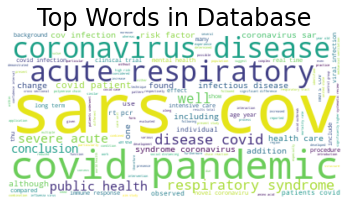

<Figure size 7200x2160 with 0 Axes>

In [298]:
#Generate and plot word cloud of training corpus
wordcloud = WordCloud(background_color="white", max_font_size = 500).generate(','.join(df_filter['abstract']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Top Words in Database',fontsize=24)
plt.axis("off")
plt.figure(figsize=(100,30))
plt.show()

### Key Word Searches

When trying to research on any topic, people try to search for articles with specific keywords. Based on this logic i searched the dataset for keywords related to pandemic, symptom, transmission, proteins (make-up), sars, mers and influenza. I searched these key words as i feel since the motivation for this assignment is to bring insight for COVID-19, i wanted to see what the papers pre-covid had to offer in these areas as they also relate to COVID-19. 

In [299]:
#focusing only on the abstract
df_abstract = df_filter['abstract']

In [300]:
#checking to see whether these words are present in each document
pandamic_word = df_abstract.apply(lambda x: np.max(np.in1d(np.asarray(x.split()), ['pandemic', 'outbreak', 'lockdown'])))
symptom_word = df_abstract.apply(lambda x: np.max(np.in1d(np.asarray(x.split()), ["symptom", "symptoms"])))
transmission_word = df_abstract.apply(lambda x: np.max(np.in1d(np.asarray(x.split()), ["transmission"])))
proteins_word = df_abstract.apply(lambda x: np.max(np.in1d(np.asarray(x.split()), ["proteins", "protein"])))
sars_word = df_abstract.apply(lambda x: np.max(np.in1d(np.asarray(x.split()), ['sars'])))
mers_word = df_abstract.apply(lambda x: np.max(np.in1d(np.asarray(x.split()), ['mers'])))
influenza_word = df_abstract.apply(lambda x: np.max(np.in1d(np.asarray(x.split()), ['influenza'])))

In [301]:
#combining all the series into a dataframe
df_new = pd.concat([df_abstract, pandamic_word,symptom_word,transmission_word,proteins_word,sars_word,mers_word,influenza_word], axis=1)

In [302]:
#renaming the columns
df_new.columns = ['abstract', 'pandemic', 'symptom', 'transmission', 'proteins', 'sars', 'mers', 'influenza']

#changing values from bool to strings to for filtering
df_new['pandemic'] = df_new['pandemic'].apply(lambda x: 'True' if x == True else 'False')
df_new['proteins'] = df_new['proteins'].apply(lambda x: 'True' if x == True else 'False')
df_new['sars'] = df_new['sars'].apply(lambda x: 'True' if x == True else 'False')
df_new['symptom'] = df_new['symptom'].apply(lambda x: 'True' if x == True else 'False')
df_new['transmission'] = df_new['transmission'].apply(lambda x: 'True' if x == True else 'False')
df_new['mers'] = df_new['mers'].apply(lambda x: 'True' if x == True else 'False')
df_new['influenza'] = df_new['influenza'].apply(lambda x: 'True' if x == True else 'False')

df_new.head()

,abstract,pandemic,symptom,transmission,proteins,sars,mers,influenza
0,objective: this retrospective chart review describes the epidemiology and clinical features of 4...,False,False,False,False,False,False,False
1,inflammatory diseases of the respiratory tract are commonly associated with elevated production ...,False,False,False,True,False,False,False
2,surfactant protein-d (sp-d) participates in the innate response to inhaled microorganisms and or...,False,False,False,False,False,False,False
3,endothelin-1 (et-1) is a 21 amino acid peptide with diverse biological activity that has been im...,False,False,False,False,False,False,False
4,respiratory syncytial virus (rsv) and pneumonia virus of mice (pvm) are viruses of the family pa...,False,False,False,False,False,False,False


Next, i search to see if there is any relationships between the papers that have each of the words in their articles. This can tell me how many articles provide insight into the relationship between the keywords. For example: I want to know if there are any papers related to pandemic and sars (this could potentially mean that there are some papers that discuss a pandemic during the sars outbreak which could be of use since covid-19 has also declared a pandemic). 

In [303]:
#searching for the 'true' intersection for all the keyword searches 
pandemic_symptom = df_new[(df_new['pandemic']=='True') & (df_new['symptom']=='True')].shape[0]
pandemic_transmission= df_new[(df_new['pandemic']=='True') & (df_new['transmission']=='True')].shape[0]
pandemic_proteins= df_new[(df_new['pandemic']=='True') & (df_new['proteins']=='True')].shape[0]
pandemic_sars= df_new[(df_new['pandemic']=='True') & (df_new['sars']=='True')].shape[0]
pandemic_mers= df_new[(df_new['pandemic']=='True') & (df_new['mers']=='True')].shape[0]
pandemic_influenza= df_new[(df_new['pandemic']=='True') & (df_new['influenza']=='True')].shape[0]
symptom_transmission= df_new[(df_new['symptom']=='True') & (df_new['transmission']=='True')].shape[0]
symptom_proteins= df_new[(df_new['symptom']=='True') & (df_new['proteins']=='True')].shape[0]
symptom_sars= df_new[(df_new['symptom']=='True') & (df_new['sars']=='True')].shape[0]
symptom_mers= df_new[(df_new['symptom']=='True') & (df_new['mers']=='True')].shape[0]
symptom_influenza= df_new[(df_new['symptom']=='True') & (df_new['influenza']=='True')].shape[0]
transmission_proteins= df_new[(df_new['transmission']=='True') & (df_new['proteins']=='True')].shape[0]
transmission_sars= df_new[(df_new['transmission']=='True') & (df_new['sars']=='True')].shape[0]
transmission_mers= df_new[(df_new['transmission']=='True') & (df_new['mers']=='True')].shape[0]
transmission_influenza= df_new[(df_new['transmission']=='True') & (df_new['influenza']=='True')].shape[0]
proteins_sars= df_new[(df_new['proteins']=='True') & (df_new['sars']=='True')].shape[0]
proteins_mers= df_new[(df_new['proteins']=='True') & (df_new['mers']=='True')].shape[0]
proteins_influenza= df_new[(df_new['proteins']=='True') & (df_new['influenza']=='True')].shape[0]
sars_mers= df_new[(df_new['sars']=='True') & (df_new['mers']=='True')].shape[0]
sars_influenza= df_new[(df_new['sars']=='True') & (df_new['sars']=='True')].shape[0]
mers_influenza= df_new[(df_new['mers']=='True') & (df_new['influenza']=='True')].shape[0]

comb_list = [pandemic_transmission, pandemic_proteins, pandemic_sars,pandemic_mers,pandemic_influenza,symptom_transmission,symptom_proteins,symptom_sars,symptom_mers,symptom_influenza,transmission_proteins,transmission_sars,transmission_mers,transmission_influenza,proteins_sars,proteins_mers,proteins_influenza,sars_mers,sars_influenza,mers_influenza
]


Plotting the results of the word combinations show which combination of words results the most amount of articles in the database. The graph is color coded to allow for easier understanding. 

Colours: 
- Red - Pandemic
- Blue - Symptoms
- Purple - Transmission
- Green - Proteins
- Yellow - Sars
- Orange - Mers 

Keeping in mind that because these are combinations of the words and i did not want repeated bars on my graph, some of the categories are mixed in with the other colours. For example: pandemic_transmission is related to pandemic and transmission but is red on the graph. The colours are more for the ease of viewing the seperation. 

[Text(0, 0.5, 'Article Count'), Text(0.5, 0, 'Word Combinations')]

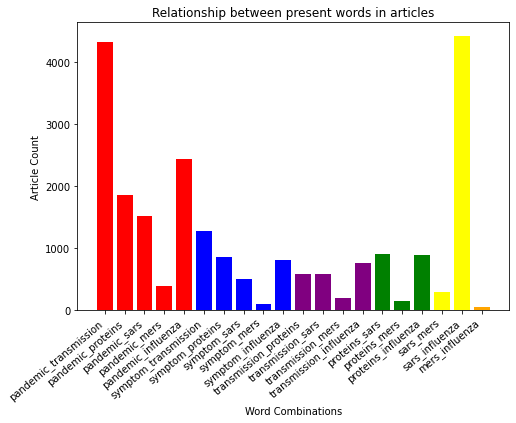

In [304]:
#plotting the results from the word combinations
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ["pandemic_transmission", "pandemic_proteins", "pandemic_sars","pandemic_mers","pandemic_influenza","symptom_transmission","symptom_proteins","symptom_sars","symptom_mers","symptom_influenza","transmission_proteins","transmission_sars","transmission_mers","transmission_influenza","proteins_sars","proteins_mers","proteins_influenza","sars_mers","sars_influenza","mers_influenza"]
ax.bar(labels,comb_list, color = ["red", "red", "red","red","red","blue","blue","blue","blue","blue","purple","purple","purple","purple","green","green","green","yellow","yellow","orange"])
ax.set_xticklabels(labels, rotation=40, ha="right")
ax.set_title("Relationship between present words in articles")
ax.set(xlabel = 'Word Combinations', ylabel = 'Article Count')

Research is based off previous research so being able to analyze and find articles that are related to past viruses is of great benefit. Because of this i also wanted to see the number of documents that talked about past viruses (sars, mers and influenza) in relation to symptoms and transmission.

[Text(0, 0.5, 'Article Count'), Text(0.5, 0, 'Virus')]

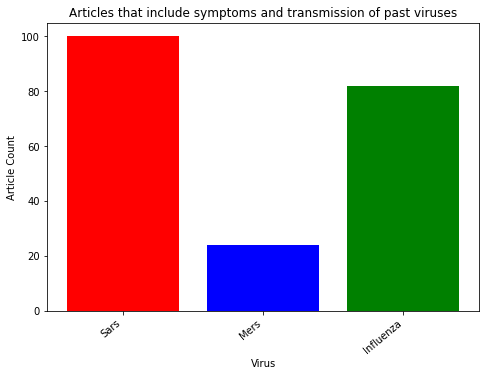

In [305]:
#creating the counts for each relationship
sars_relation= df_new[(df_new['sars']=='True') & (df_new['symptom']=='True')& (df_new['transmission']=='True')].shape[0]
mers_relation= df_new[(df_new['mers']=='True') & (df_new['symptom']=='True')& (df_new['transmission']=='True')].shape[0]
influenza_relation= df_new[(df_new['influenza']=='True') & (df_new['symptom']=='True')& (df_new['transmission']=='True')].shape[0]

#creating list with counts 
virus_list = [sars_relation,mers_relation,influenza_relation]
virus_labels = ['Sars', 'Mers', 'Influenza']

#plotting the results from the word combinations
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(virus_labels,virus_list, color = ['red', 'blue', 'green'])
ax.set_xticklabels(virus_labels, rotation=40, ha="right")
ax.set_title("Articles that include symptoms and transmission of past viruses")
ax.set(xlabel = 'Virus', ylabel = 'Article Count')

Based off the graph you can see that most of the articles are related to pandemics with relation to transmissions and sars in relation to influenza. Knowing this, we can extract the artciles that are included in these counts in hopes that they reflect these word combinations and begin analyzing them to see if there is any information that can be used for insights of COIVD-19. However, this approach is not exactly great. Just because an article has the word present does not mean that the article is going to be about that. We dont know how many times that word shows up in the article or any other context. 

Same thing goes for the past viruses graph. The graph tells us that sars and influenza have many artciles in relation to symptoms and transmission that can be explored but not many mers articles. This may be true, but the issue with this approach is the same as mentioned above.

However, knowing the topics of documents and knowing their relationship to each other based on their topics is very beneficial for researchers. The idea of trying to extract papers that discuss sars and transmission for example, can be of great use to COVID-19 researchers as the make up of viruses could be similar and therefore lead to more insights into COIVD-19. Knowing the topics of each document can ultimately set up researchers to be able to easily find what they are looking for and allow for efficient research. 

## (3) Model Selection and fitting to Data

I chose to implement an LDA model as these models are known for discovering hidden themes in a collection of documents/text. As the goal of this approach is to organize and allow for easy search and summarization for researchers, this approach was deemed appropriate. Other topic modelling techniques include LSA, PLSA, NMF and more. LDA was specifically chosen as it was briefly mentioned in the course and typically provides good results based on online literature. 

LDA topic modelling is done to determine the topics of each of the documents. Aside from providing the classified topic for each document it also provides the distribution of the topics for each document as an article can realistically have more than one topic.This is also beneficial to know as it allows researchers to view the relationship certain topics have with others. For example: if a document is deemed 60% related to topic 1 (lets say symptons) and 40% related to topic 2 (lets say public policy) then the paper could potentially discuss the relationship between symptons and the community or how symptons affect public policy and so on. 

The dominant topics of all the topics will then be used as the target variables for the text classification model in the next section. 

Implementation of LDA topic modelling can be applied through libraries such sklearn and gensim. For this model i used gensim. 

All LDA related code sources used for implementation:
-  https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
-  https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

### Preparing text for LDA modelling

Using the gensim libary to prepare the data for topic modelling with LDA (Latent Dirichlet Allocation). For text cleaning the following will be done: 
- filtering out stop words as well as general words that are common within all the papers to allow for more distinct topics
- Lemmatization of words (not stemming the words because i find that when the words are stemmed a lot of medical terms are stemmed into meaningless words)
- gensim simple preprocess
- Create Bigrams

#### Stop Words 

In [306]:
#creating a new stop words set to include extra words that i have added
my_stop_words = STOPWORDS.union(set(['from', 'subject', 're', 'edu', 'use', 'infection', 'virus', 'patient', 'model','study','patients', 'sars', 'disease', 'case', 'covid', 'result', 'results']))

#### Lemmatizing and Preprocessing 

In [307]:
#function for lemmatizing
def lemmatizing(text):
    return WordNetLemmatizer().lemmatize(text, pos='v')
#applying gensims pre-procesing function,  lemmatizing function and removing any tokens less than 3 characters
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in my_stop_words and len(token) > 3:
            result.append(lemmatizing(token))
    return result

In [308]:
#applying the preprocess function and outputting the first 10 rows
processed_docs = df_filter['abstract'].map(preprocess)
processed_docs[:10]

0    [objective, retrospective, chart, review, describe, epidemiology, clinical, feature, culture, pr...
1    [inflammatory, diseases, respiratory, tract, commonly, associate, elevate, production, nitric, o...
2    [surfactant, protein, participate, innate, response, inhale, microorganisms, organic, antigens, ...
3    [endothelin, amino, acid, peptide, diverse, biological, activity, implicate, numerous, diseases,...
4    [respiratory, syncytial, pneumonia, mice, viruses, family, paramyxoviridae, subfamily, pneumovir...
5    [nidovirus, subgenomic, mrnas, contain, leader, sequence, derive, genome, fuse, different, seque...
6    [recent, evidence, suggest, critically, able, tolerate, lower, level, haemoglobin, previously, b...
7    [international, symposium, intensive, care, emergency, medicine, dominate, recent, clinical, tri...
8    [heme, oxygenase, inducible, stress, protein, confer, cytoprotection, oxidative, stress, vitro, ...
9    [report, describe, design, implementation, real, t

#### Bigrams

In [309]:
#preparing for bigram model
data_words = processed_docs.tolist()

I applied a bigram model to bring more insight into the word frequencies. It is obvious that some words as a stand alone do not mean much. I used bigrams to try to add more context to works and aid in better topic modelling. 

For the bigram model, i tried different thresholds to see the difference it would make to the output of the LDA model thorugh trial and error. I acknowledge that this approach is not very efficient and/or reliable however the computation time to go through several thresholds and then test them on the LDA model was not feasible (attempted this but always got runtime error). Therefore after using trial and error a threshold of 50 was chosen since it yielded the most distinct topics.

In [310]:
# Building the bigram model
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=50) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [311]:
# Define functions bigrams 
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [312]:
# Applying Bigrams function
data_words_bigrams = make_bigrams(data_words)
print(data_words_bigrams[:1])

[['objective', 'retrospective_chart', 'review', 'describe', 'epidemiology', 'clinical', 'feature', 'culture', 'prove', 'mycoplasma_pneumoniae', 'infections', 'king_abdulaziz', 'university', 'hospital', 'jeddah_saudi', 'arabia', 'methods', 'positive', 'pneumoniae', 'culture', 'respiratory', 'specimens', 'january_december', 'identify', 'microbiology', 'record', 'chart_review', 'identify', 'require', 'admission', 'infections', 'community_acquire', 'affect', 'group', 'common', 'infants', 'school', 'children', 'occur', 'year', 'round', 'common', 'fall', 'spring', 'three', 'quarter', 'comorbidities', 'twenty', 'four', 'isolate', 'associate', 'pneumonia', 'upper', 'respiratory_tract', 'infections', 'bronchiolitis', 'cough', 'fever_malaise', 'common', 'symptoms', 'crepitations', 'wheeze', 'common', 'sign', 'pneumonia', 'crepitations', 'bronchial', 'breathe', 'likely', 'present', 'pneumonia', 'versus', 'pneumonia', 'uneventful_recovery', 'recover', 'follow', 'complications', 'die', 'pneumoniae'

### LDA Topic Modelling

In [313]:
# Create Dictionary
id2word_data = corpora.Dictionary(data_words_bigrams)

# Assign Corpus
texts_data = data_words_bigrams

# Term Document Frequency (using .doc2bow which is using bag of words)
corpus_data = [id2word_data.doc2bow(text) for text in texts_data]


Before running the LDA model i needed to determine how many topics i wanted the model to find. At first i tried trial and error from 3-10 number of topics (alpha being 'auto') with comparing the words and their relevency scores to the topics (from the interative gensim visualization). This resulted to 3 and 7 being relatively the best so then i ran tests to see what alpha value will give me the best coherence score with both those number of topics. I chose to tune the alpha parameter as alpha controls the topic weights for each document.

Note: When i first tried tuning it would cause my colab to crash so i made a copy of this notebook to run it there and that allowed it to finish running (3 hours later) once i got the results i inputted them into my original notebook and then pasted the tuning code back into the original notebook for submission hence why there is no number in the run cell.

Source code: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [ ]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a):
    
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=10,
                                           chunksize=50,
                                           passes=2,
                                           alpha=a,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word_data, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
#timing the run
start = time.time()

grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 3
max_topics = 8
step_size = 4
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1))
alpha.append('auto')
alpha.append('symmetric')
alpha.append('asymmetric')

# Validation sets
num_of_docs = len(data_words_bigrams)
model_results = {
                 'Topics': [],
                 'Alpha': [],
                 'Coherence': []}

# iterate through number of topics
for k in topics_range:
  # iterate through alpha values
    for a in alpha:
    #get the coherence score for the given parameters
      cv = compute_coherence_values(corpus=corpus_data, dictionary=id2word_data, 
                                                  k=k, a=a)
      # Save the model results
      model_results['Topics'].append(k)
      model_results['Alpha'].append(a)
      model_results['Coherence'].append(cv)

#saving model results                     
pd.DataFrame(model_results).to_csv('lda_tuning_results_0.csv', index=False)

print('\nRuntime (s): ', round(time.time()-start, 2))


Runtime (s):  9439.28


In [ ]:
#displaying model results
model_results = pd.DataFrame(model_results)
model_results

,Topics,Alpha,Coherence
0,3,0.01,0.533030
1,3,auto,0.540072
2,3,symmetric,0.540448
3,3,asymmetric,0.540448
4,7,0.01,0.533530
5,7,auto,0.531027
6,7,symmetric,0.522042
7,7,asymmetric,0.533307


Based on the model tuning results i will be using 3 as the number of topics and 'symmetric' for the alpha value. 

In [314]:
# LDA model with 3 topics
lda_model_0 = gensim.models.ldamodel.LdaModel(corpus=corpus_data,
                                           id2word=id2word_data,
                                           num_topics=3, 
                                           random_state=10,
                                           update_every=1,
                                           chunksize=50,
                                           passes=2,
                                           alpha= 'symmetric',
                                           per_word_topics=True)

# Print the Keywords in the 3 topics 
pprint(lda_model_0.print_topics())
doc_lda_0 = lda_model_0[corpus_data]

# Compute Perplexity
# Perplexity score measures how well the model predicts a sample (a lower perplexity score is better)
print('\nPerplexity: ', lda_model_0.log_perplexity(corpus_data)) 

# Compute Coherence Score
# Coherence score assesses the quality of the learned topics (a higher coherence score is better)
coherence_model_lda = CoherenceModel(model=lda_model_0, texts=data_words_bigrams, dictionary=id2word_data, coherence='c_v')
coherence_lda_0 = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda_0)


[(0,
  '0.013*"health" + 0.006*"use" + 0.006*"data" + 0.005*"risk" + 0.005*"public" '
  '+ 0.004*"transmission" + 0.004*"control" + 0.004*"research" + 0.004*"base" '
  '+ 0.004*"outbreak"'),
 (1,
  '0.016*"respiratory" + 0.011*"clinical" + 0.011*"infections" + '
  '0.009*"influenza" + 0.009*"sample" + 0.009*"children" + 0.009*"group" + '
  '0.008*"test" + 0.008*"viruses" + 0.008*"associate"'),
 (2,
  '0.010*"viral" + 0.009*"cells" + 0.008*"viruses" + 0.007*"protein" + '
  '0.006*"use" + 0.006*"cell" + 0.006*"sequence" + 0.006*"host" + '
  '0.006*"human" + 0.006*"show"')]

Perplexity:  -8.59449051297284

Coherence Score:  0.5399641190091028


The visualization below is a great way to determine what each topic means. Since the circles do not overlap and are relatively far from each other that means that the topics do not intersect too much with each other. By clicking on the circles and playing with the relevance metric i was able to classify the 3 topics that were group together as the following: 

Topic 1: Public Policy 
- Main words that convinced me this topic was public policy: public, transmission, outbreak, pandemic, information, emerge, outbreaks, epidemic, global

Topic 2: Symptoms and Diagnosis
- Main words  that convinced me this topic was public policy: respiratory, children, detection, pneumonia, diagnosis, symptoms, treatement, infections, test, detect (and if you bring down the relevancy you will see more symptomatic words like cough, bronchiolitis)

Topic 3: Virus and Vaccine Development
- Main words that convinced me this topic was public policy: cells, protein, host, strain, gene, replication, target, species, antiviral, bind

Note: If the model is rerun the order of the topics changes. So if rerun and the text coded topics of the topics dont make sense it is because they have been coded to match with the originally run model. The keywords and topics will still be the same, just the ordering will be different. 

In [315]:
# Visualizing the LDA topics 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_0, corpus_data, id2word_data)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.067265 -0.189159       1        1  44.255460
1     -0.220060  0.043391       2        1  30.649363
2      0.152795  0.145767       3        1  25.095177, topic_info=            Term          Freq         Total Category  logprob  loglift
58   respiratory  83644.000000  83644.000000  Default  30.0000  30.0000
361       health  98401.000000  98401.000000  Default  29.0000  29.0000
8       children  47967.000000  47967.000000  Default  28.0000  28.0000
152        cells  37260.000000  37260.000000  Default  27.0000  27.0000
283        viral  79422.000000  79422.000000  Default  26.0000  26.0000
..           ...           ...           ...      ...      ...      ...
26          find  16720.987705  58315.151181   Topic3  -5.5349   0.1333
203     response  12463.122946  29236.689412   Topic3  -5.8288   0.5298
32      identify  14017.996076  55476.841569   Topic3  -5.7112   0.0069
380        study  12726.774493  42227.741676   Topic3  -5.8079   0.1831
294    different  12415.547528  32164.828618   Topic3  -5.8326   0.4306

[250 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1349      1  0.999844      access
1349      2  0.000181      access
3222      1  0.000198  activation
3222      3  0.999728  activation
217       1  0.045659    activity
...     ...       ...         ...
238       3  0.130182        will
1929      1  0.999918     workers
1929      2  0.000235     workers
1930      1  0.961601       world
1930      3  0.038320       world

[495 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

#### Wordcloud of Top Features

Wordclouds are another good way to visualize the keywords in the topics. The 3 wordlouds below essentialy mimic the pyLDAvis top words above. The words are limited to 10 words as only 10 are used to create the topic models. 

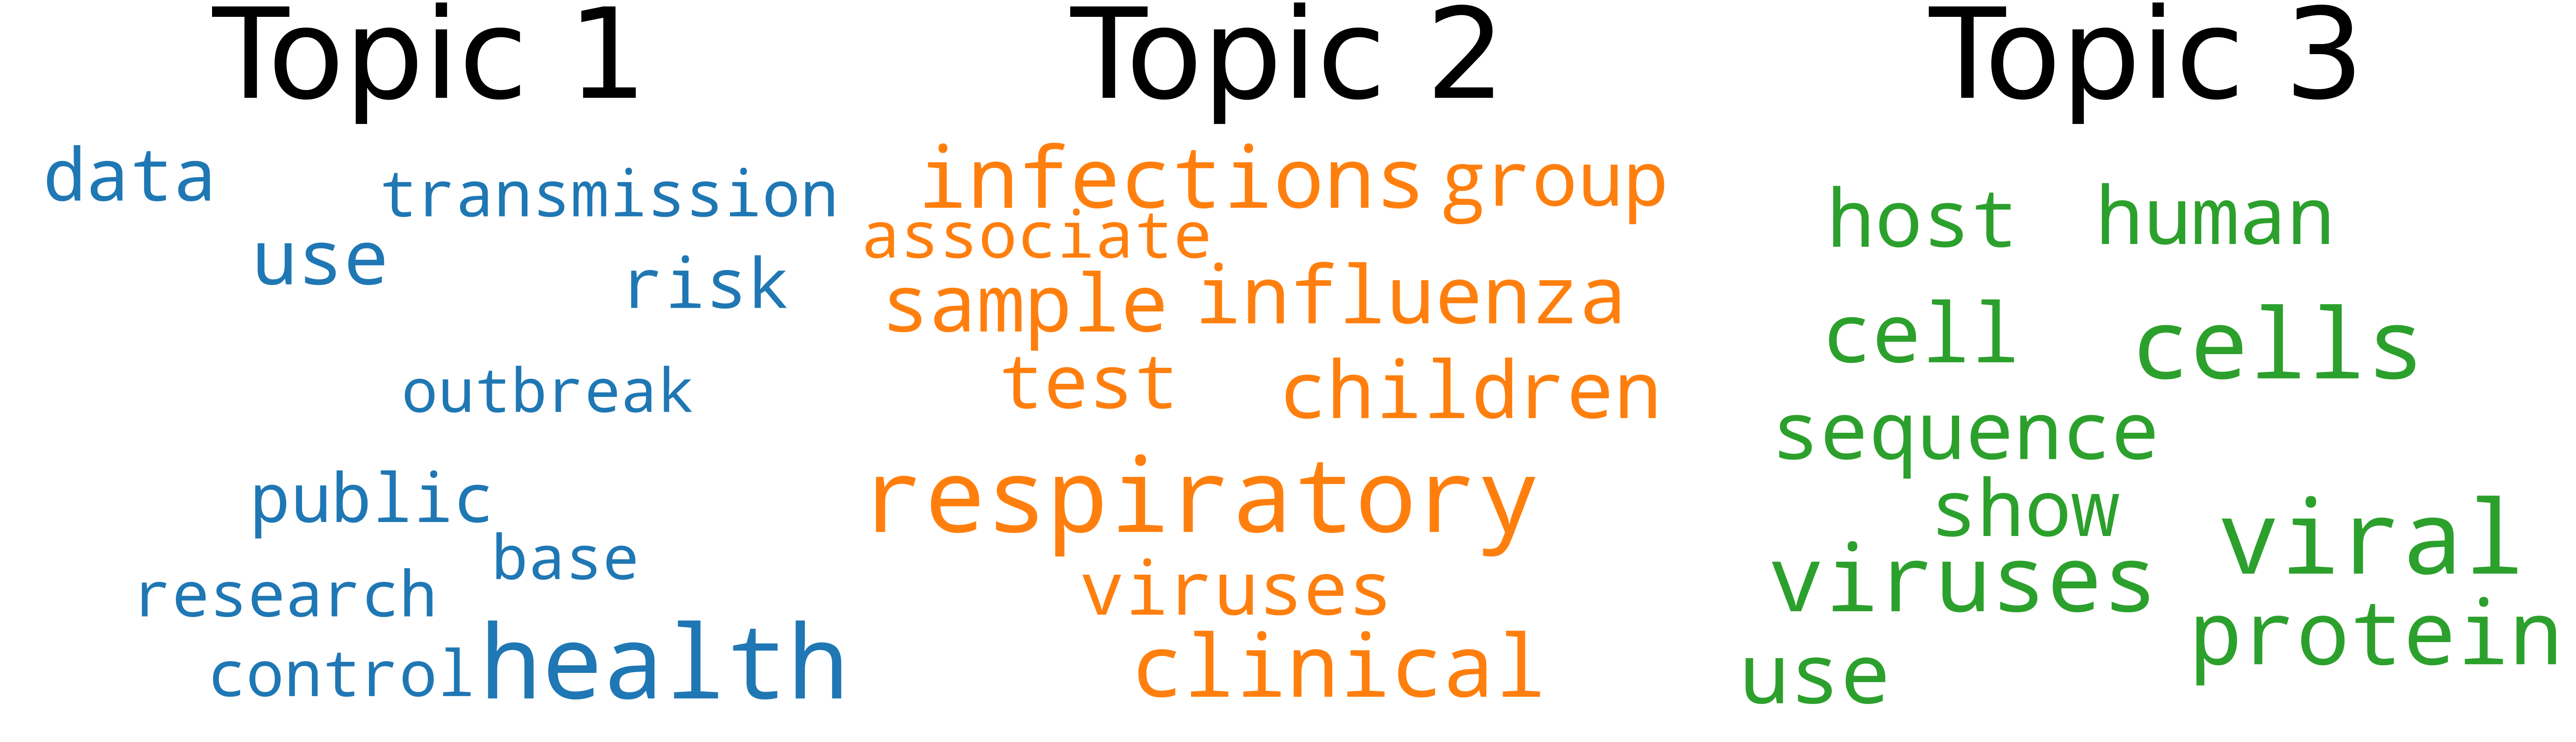

In [316]:
# 1. Wordcloud of Top 10 words in each topic

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()] 

cloud = WordCloud(stopwords=my_stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model_0.show_topics(formatted=False)

fig, axes = plt.subplots(1,3, figsize=(100,30), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=350))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

#### Allocating Topics to Papers

Now we have the topic distributions for each document, the keywords from the model, and our text. As the topic distribution for each topic is important to note, each document should realistically be assigned one dominant topic. You can still view the distribution of the topics if you want at this point but creating a new dataframe with the dominant topic of each document allows for better analysis and easier search. 

In [317]:
start = time.time()
def format_topics_sentences(ldamodel=None, corpus=corpus_data, texts=data_words_bigrams):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus_data]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add cleaned text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

#running the function to determine the dominant topic of each document
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_0, corpus=corpus_data, texts=data_words_bigrams)

# Formatting
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
print('\nRuntime (s): ', round(time.time()-start, 2))
df_dominant_topic.head(10)



Runtime (s):  2116.43


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.9576,"respiratory, clinical, infections, influenza, sample, children, group, test, viruses, associate","[objective, retrospective_chart, review, describe, epidemiology, clinical, feature, culture, pro..."
1,1,2.0,0.6438,"viral, cells, viruses, protein, use, cell, sequence, host, human, show","[inflammatory, diseases, respiratory_tract, commonly, associate, elevate, production, nitric_oxi..."
2,2,2.0,0.9028,"viral, cells, viruses, protein, use, cell, sequence, host, human, show","[surfactant, protein, participate, innate, response, inhale, microorganisms, organic, antigens, ..."
3,3,2.0,0.8650,"viral, cells, viruses, protein, use, cell, sequence, host, human, show","[endothelin, amino_acid, peptide, diverse, biological, activity, implicate, numerous, diseases, ..."
4,4,2.0,0.8561,"viral, cells, viruses, protein, use, cell, sequence, host, human, show","[respiratory_syncytial, pneumonia, mice, viruses, family_paramyxoviridae, subfamily, pneumovirus..."
5,5,2.0,0.9944,"viral, cells, viruses, protein, use, cell, sequence, host, human, show","[nidovirus, subgenomic_mrnas, contain, leader_sequence, derive, genome, fuse, different, sequenc..."
6,6,1.0,0.5318,"respiratory, clinical, infections, influenza, sample, children, group, test, viruses, associate","[recent, evidence, suggest, critically, able, tolerate, lower, level, haemoglobin, previously, b..."
7,7,0.0,0.5920,"health, use, data, risk, public, transmission, control, research, base, outbreak","[international, symposium, intensive_care, emergency, medicine, dominate, recent, clinical, tria..."
8,8,2.0,0.8459,"viral, cells, viruses, protein, use, cell, sequence, host, human, show","[heme_oxygenase, inducible, stress, protein, confer, cytoprotection, oxidative_stress, vitro_viv..."
9,9,0.0,0.7908,"health, use, data, risk, public, transmission, control, research, base, outbreak","[report, describe, design, implementation, real_time, outbreak, surveillance, rods, system, comp..."


In [318]:
df_dominant_topic.to_csv('df_dominant_topic.csv')

In [319]:
#to concatenate the original abstract to the new dataframe i made each column i wanted in the new dataframe into a list and then joined them together to make one Dataframe
domtop_list = df_dominant_topic['Dominant_Topic'].values.tolist()
top_per_list = df_dominant_topic['Topic_Perc_Contrib'].values.tolist()
keywords_list = df_dominant_topic['Keywords'].values.tolist()
text_list = df_dominant_topic['Text'].values.tolist()
abstract_list = df_filter['abstract'].values.tolist()

df_data = pd.DataFrame(
    {'Dominant_Topic': domtop_list,'Topic_Perc_Contrib': top_per_list,'Keywords': keywords_list,'Text': text_list, 'abstract': abstract_list})

In [327]:
# Creating another column to label topics 
classified_topics = {0:'Public Policy', 1:'Symptoms and diagnosis', 2:'Virus and vaccine development'}
df_data['topic'] = df_data['Dominant_Topic'].map(classified_topics)

In [328]:
#size of dataframe
df_data.shape

(166428, 6)

To create the final dataframe of the LDA model results i removed all the documents that had less than a 50% dominant topic distribution. I removed these because even though that topic was deemed the most dominant topic in that paper, that paper did not resemble that topic that well meaning that paper most likely did not resemble any of the topics that well. Therefore to avoid grouping papers together that are not actually the same topic, these are removed. 10,918 documents out of 166,404 were removed (6.5%). 

Since there were many documents over the 50% mark, this could be an indicator that maybe 3 topics is not actually the best number of topics (considering the approach taken to get the best number was through trial and error to determine 2 topic numbers to tune with this is probable). However, since it was only 6.5% of the original dataset and as i mentioned earlier about other methods of tuning being computationally unfeasible currently (timing out, crashes etc) i moved on. 

In [329]:
#filtering out the document that had less than a 50% dominant topic distribution
df_final = df_data[df_data['Topic_Perc_Contrib'] > 0.5]
df_final.shape

(155448, 6)

In [331]:
df_final.head()

,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,abstract,topic
0,1.0,0.9576,"respiratory, clinical, infections, influenza, sample, children, group, test, viruses, associate","[objective, retrospective_chart, review, describe, epidemiology, clinical, feature, culture, pro...",objective: this retrospective chart review describes the epidemiology and clinical features of 4...,Symptoms and diagnosis
1,2.0,0.6438,"viral, cells, viruses, protein, use, cell, sequence, host, human, show","[inflammatory, diseases, respiratory_tract, commonly, associate, elevate, production, nitric_oxi...",inflammatory diseases of the respiratory tract are commonly associated with elevated production ...,Virus and vaccine development
2,2.0,0.9028,"viral, cells, viruses, protein, use, cell, sequence, host, human, show","[surfactant, protein, participate, innate, response, inhale, microorganisms, organic, antigens, ...",surfactant protein-d (sp-d) participates in the innate response to inhaled microorganisms and or...,Virus and vaccine development
3,2.0,0.8650,"viral, cells, viruses, protein, use, cell, sequence, host, human, show","[endothelin, amino_acid, peptide, diverse, biological, activity, implicate, numerous, diseases, ...",endothelin-1 (et-1) is a 21 amino acid peptide with diverse biological activity that has been im...,Virus and vaccine development
4,2.0,0.8561,"viral, cells, viruses, protein, use, cell, sequence, host, human, show","[respiratory_syncytial, pneumonia, mice, viruses, family_paramyxoviridae, subfamily, pneumovirus...",respiratory syncytial virus (rsv) and pneumonia virus of mice (pvm) are viruses of the family pa...,Virus and vaccine development


#### Most Representative Documents

Just as grouping the documents into topics makes it easier for researchers to find more relevant papers, finding the most representative documents for each topic allows researchers to quickly and easily read papers that are the most focused on that topic. Some researchers prefer to have a mix of topics as they want to see the relationship, however, for example: if someone was interested soley on exploring the virus development (maybe they want to compare other virus developments to past developments for treatement purposes) they can easily find the most representative paper first and then dig deeper if needed.

In [332]:
# formatting to allow more words to be shown in the coloumns 
pd.options.display.max_colwidth = 100

#creating dataframe
sent_topics = pd.DataFrame()
sent_topics_grouped = df_topic_sents_keywords.groupby('Dominant_Topic')

#iterating over the topic distribution percents in the topic groups 
for i, grp in sent_topics_grouped:
    sent_topics = pd.concat([sent_topics, 
                            grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                            axis=0)

# Resetting index  
sent_topics.reset_index(drop=True, inplace=True)

# Formatting
sent_topics.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9982,"health, use, data, risk, public, transmission, control, research, base, outbreak","[purpose, increase, risk, natural_disasters, challenge, humanitarian, actors, create, resilient,..."
1,1.0,0.9963,"respiratory, clinical, infections, influenza, sample, children, group, test, viruses, associate","[background, differentiate, bacterial, viral, pneumonia, important, guide, target, management, j..."
2,2.0,0.9979,"viral, cells, viruses, protein, use, cell, sequence, host, human, show","[influenza, viruses, envelop, negative, strand, segment, viruses, belong, family, virion, consis..."


#### Exploring Topics

In [333]:
#getting value counts of each topic
df_final['topic'].value_counts()

Public Policy                    71585
Symptoms and diagnosis           44834
Virus and vaccine development    39029
Name: topic, dtype: int64

(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

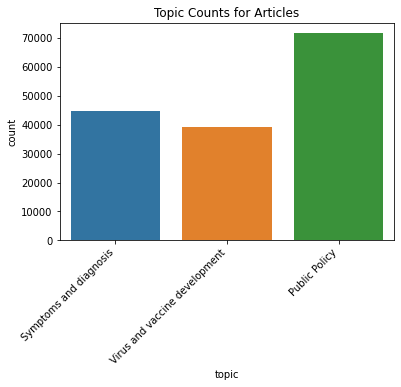

In [334]:
#plotting the value counts for each topic
ax = sns.countplot(x='topic', data=df_final)
ax.set_title("Topic Counts for Articles")
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',  
)

In [335]:
#getting the feature vectors from LDA model
vectors = []
for i in range(len(data_words_bigrams)):
    top_topics = lda_model_0.get_document_topics(corpus_data[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(3)]
    vectors.append(topic_vec)

In [336]:
#creating dataframe of the vectors and labelling them accordingly
vectors_df = pd.DataFrame(vectors)
vectors_df.columns = ['public_policy','symptoms_diagnosis' ,'virus_vaccine' ]

In [337]:
#combining the original dataframe with the topic distributions
result_df = pd.concat([df_final, vectors_df], axis=1)
result_df.head()

,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,abstract,topic,public_policy,symptoms_diagnosis,virus_vaccine
0,1.0,0.9576,"respiratory, clinical, infections, influenza, sample, children, group, test, viruses, associate","[objective, retrospective_chart, review, describe, epidemiology, clinical, feature, culture, pro...",objective: this retrospective chart review describes the epidemiology and clinical features of 4...,Symptoms and diagnosis,0.038375,0.957629,0.003997
1,2.0,0.6438,"viral, cells, viruses, protein, use, cell, sequence, host, human, show","[inflammatory, diseases, respiratory_tract, commonly, associate, elevate, production, nitric_oxi...",inflammatory diseases of the respiratory tract are commonly associated with elevated production ...,Virus and vaccine development,0.211409,0.144756,0.643835
2,2.0,0.9028,"viral, cells, viruses, protein, use, cell, sequence, host, human, show","[surfactant, protein, participate, innate, response, inhale, microorganisms, organic, antigens, ...",surfactant protein-d (sp-d) participates in the innate response to inhaled microorganisms and or...,Virus and vaccine development,0.019816,0.077374,0.902810
3,2.0,0.8650,"viral, cells, viruses, protein, use, cell, sequence, host, human, show","[endothelin, amino_acid, peptide, diverse, biological, activity, implicate, numerous, diseases, ...",endothelin-1 (et-1) is a 21 amino acid peptide with diverse biological activity that has been im...,Virus and vaccine development,0.008808,0.126199,0.864993
4,2.0,0.8561,"viral, cells, viruses, protein, use, cell, sequence, host, human, show","[respiratory_syncytial, pneumonia, mice, viruses, family_paramyxoviridae, subfamily, pneumovirus...",respiratory syncytial virus (rsv) and pneumonia virus of mice (pvm) are viruses of the family pa...,Virus and vaccine development,0.004729,0.139168,0.856103


No handles with labels found to put in legend.


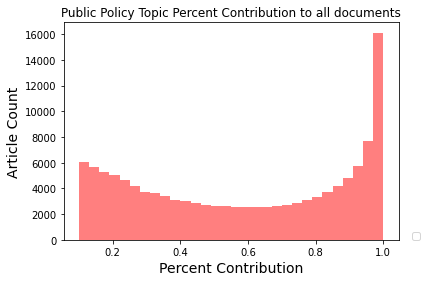

In [338]:
#histogram of public policy distrbution ranging from 10% to 100%
plt.hist(result_df.public_policy,range=(0.1,1), bins = 30, alpha=0.5, color = 'red')
plt.xlabel("Percent Contribution", size = 14)
plt.ylabel("Article Count", size = 14)
plt.title('Public Policy Topic Percent Contribution to all documents')
plt.legend(loc=(1.04,0))

No handles with labels found to put in legend.


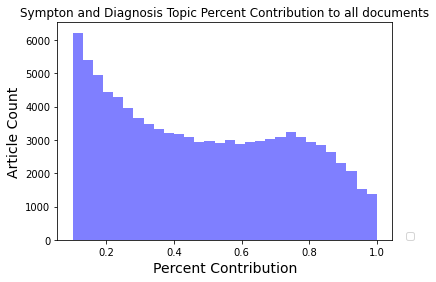

In [339]:
#histogram of symptom and diagnosis ranging from 10% to 100%
plt.hist(result_df.symptoms_diagnosis, range=(0.1,1), bins = 30, alpha=0.5, color = 'blue')
plt.xlabel("Percent Contribution", size = 14)
plt.ylabel("Article Count", size = 14)
plt.title('Sympton and Diagnosis Topic Percent Contribution to all documents')
plt.legend(loc=(1.04,0))

No handles with labels found to put in legend.


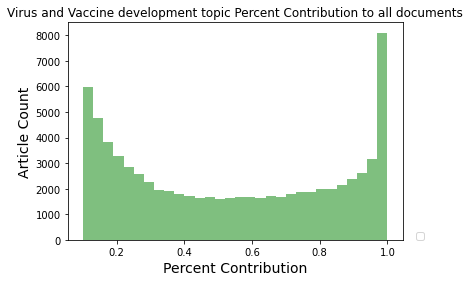

In [411]:
#histogram of virus and vaccine development ranging from 10% to 100%
plt.hist(result_df.virus_vaccine,range=(0.1,1), bins = 30, alpha=0.5, color = 'green')
plt.xlabel("Percent Contribution", size = 14)
plt.ylabel("Article Count", size = 14)
plt.title('Virus and Vaccine development topic Percent Contribution to all documents')
plt.legend(loc=(1.04,0))

When looking at the distributions of each topic, you can see that a lot of the papers include public policy even if its a minimal percentage amount. You can also note here that the topics public policy and virus and vaccine development topics have papers in the database that are almost 100% related to that topic.

### Text Classification

Since the text data that was given did not have a target variable, LDA topic modelling was used to obtain relevant topics for each document and will be used as the target variable for text classification models.

SVM and Naive Bayes were chosen because there are known to be the most popular text classification methods aside from deep learning.

Text classification modelling is not necessarily needed as an extension to the LDA topic modelling in this case as i am using the topics found as the target variables. Therefore i am treating the data set as if it was a new dataset that was given to me with the target variable of the topics already assigned. This section is more to show how the LDA topic model can be even further extended into the use of a classification model to offer even more insights depending on what the researcher is exactly trying to accomplish. Since the target variable in this case were pre-assigned based off the data i am using, it would make no sense to use the Lda feature vector as an input as it would return almost 100% accuracy which is why i will be training and testing with TF-IDF vectors on the preprocessed data. This should still give me a high accuracy as i am still using the same preprocessed data but using a different feature vectorizer.

In a case where the target variable is given in a dataset pre lda topic modelling, the feature vectors from the lda model can be used on a classification model for better prediction accuracies. 

In [341]:
# Dataset
dataset = df_final[['Dominant_Topic', 'topic','Text', 'abstract']]
dataset.head()

,Dominant_Topic,topic,Text,abstract
0,1.0,Symptoms and diagnosis,"[objective, retrospective_chart, review, describe, epidemiology, clinical, feature, culture, pro...",objective: this retrospective chart review describes the epidemiology and clinical features of 4...
1,2.0,Virus and vaccine development,"[inflammatory, diseases, respiratory_tract, commonly, associate, elevate, production, nitric_oxi...",inflammatory diseases of the respiratory tract are commonly associated with elevated production ...
2,2.0,Virus and vaccine development,"[surfactant, protein, participate, innate, response, inhale, microorganisms, organic, antigens, ...",surfactant protein-d (sp-d) participates in the innate response to inhaled microorganisms and or...
3,2.0,Virus and vaccine development,"[endothelin, amino_acid, peptide, diverse, biological, activity, implicate, numerous, diseases, ...",endothelin-1 (et-1) is a 21 amino acid peptide with diverse biological activity that has been im...
4,2.0,Virus and vaccine development,"[respiratory_syncytial, pneumonia, mice, viruses, family_paramyxoviridae, subfamily, pneumovirus...",respiratory syncytial virus (rsv) and pneumonia virus of mice (pvm) are viruses of the family pa...


In [342]:
#function to convert to string to allow for easier manipulation as seen below
def listToString(s):  
    
    # initialize an empty string 
    str1 = " " 
    
    # return string   
    return (str1.join(s)) 

In [343]:
#converting to a string
dataset['string'] = dataset['Text'].apply(listToString)
dataset.head()

,Dominant_Topic,topic,Text,abstract,string
0,1.0,Symptoms and diagnosis,"[objective, retrospective_chart, review, describe, epidemiology, clinical, feature, culture, pro...",objective: this retrospective chart review describes the epidemiology and clinical features of 4...,objective retrospective_chart review describe epidemiology clinical feature culture prove mycopl...
1,2.0,Virus and vaccine development,"[inflammatory, diseases, respiratory_tract, commonly, associate, elevate, production, nitric_oxi...",inflammatory diseases of the respiratory tract are commonly associated with elevated production ...,inflammatory diseases respiratory_tract commonly associate elevate production nitric_oxide incre...
2,2.0,Virus and vaccine development,"[surfactant, protein, participate, innate, response, inhale, microorganisms, organic, antigens, ...",surfactant protein-d (sp-d) participates in the innate response to inhaled microorganisms and or...,surfactant protein participate innate response inhale microorganisms organic antigens contribute...
3,2.0,Virus and vaccine development,"[endothelin, amino_acid, peptide, diverse, biological, activity, implicate, numerous, diseases, ...",endothelin-1 (et-1) is a 21 amino acid peptide with diverse biological activity that has been im...,endothelin amino_acid peptide diverse biological activity implicate numerous diseases potent mit...
4,2.0,Virus and vaccine development,"[respiratory_syncytial, pneumonia, mice, viruses, family_paramyxoviridae, subfamily, pneumovirus...",respiratory syncytial virus (rsv) and pneumonia virus of mice (pvm) are viruses of the family pa...,respiratory_syncytial pneumonia mice viruses family_paramyxoviridae subfamily pneumovirus cause ...


In [344]:
#Fetch wordcount for each abstract
dataset['word_count_abstract'] = dataset['abstract'].apply(lambda x: len(str(x).split(" ")))
dataset['word_count_text'] = dataset['string'].apply(lambda x: len(str(x).split(" ")))
dataset[['word_count_abstract','word_count_text']].head()

,word_count_abstract,word_count_text
0,262,101
1,142,73
2,219,115
3,68,33
4,110,63


In [345]:
# re-formatting dataframe
df_dataset = dataset[['Dominant_Topic','topic', 'Text','abstract', 'string']]

In [346]:
# Assigning featuer and target variables
y = df_dataset['Dominant_Topic']
X = df_dataset['string'] #preprocessed text

#### Split Train-Test

In [347]:
#train, test split for the classification model with target variable 'Dominant_Topic' from LDA model and pre=processed text as the features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#### Feature Encoding

I chose to do TF-IDF since the LDA model incorporated BOW so i wanted to try a different method and as TF-IDF essentialy is an extension to bow i wanted to see the difference.

In [348]:
# TF-IDF feature encoding.
TFIDF = TfidfVectorizer(use_idf=True, smooth_idf=True, norm=None, max_features = 200).fit(X_train)
TFIDFx_train = TFIDF.transform(X_train).toarray()
TFIDFx_test= TFIDF.transform(X_test).toarray()

##### Naive Bayes 

In [349]:
#function for Naive Bayes model
def NB(X_train, X_test, y_train, y_test):

    NB_model = MultinomialNB()
    NB_model.fit(X_train, y_train)
    predictions = NB_model.predict(X_test)

    ACC = accuracy_score(y_test, predictions)
    
    return ACC

In [350]:
#running the model with bow and TF-IDF and printing out the accuracy scores
NB_TFIDF = NB(TFIDFx_train, TFIDFx_test, y_train, y_test)
print('TF-IDF Accuracy Score: %.5f' % (NB_TFIDF))

TF-IDF Accuracy Score: 0.88787


##### Support Vector Machine

In [351]:
#function for Linear SVC model
def SVM(X_train, X_test, y_train, y_test):
    
    SVM_model = LinearSVC()
    SVM_model.fit(X_train, y_train)
    predictions = SVM_model.predict(X_test)

    ACC = accuracy_score(y_test, predictions)
    
    return ACC

In [352]:
#running the model with bow and TF-IDF and printing out the accuracy scores
SVM_TFIDF = SVM(TFIDFx_train, TFIDFx_test, y_train, y_test)
print('TF-IDF Accuracy Score: %.5f' % (SVM_TFIDF))

TF-IDF Accuracy Score: 0.89607


As assumed, the accuracies for both models are very high. This makes sense as the data is the exact same and only method for feature encoding differ.

### LDA modelling with new (unseen) Covid Papers

A very useful feature of lda topic modelling is the ability to determine the topic distribution of unseen data. Meaning that if you find a paper or even several more papers that seem that they may be relevent, you can use the lda model to determine the distribution of topics that they relate to. This allows you to keep a database of updated grouped research papers as well as allows you to determine what the main topics of the papers are before even reading them.

Example: since i filtered out all the covid papers from the database when creating the lda model, those papers are considered unseen. Now that covid-19 is clearly more relevant as many papers are being published, it is helpful to know what topic those papers are tackling. When knowing the relationship between the covid-19 papers and the papers pre-covid, researchers can create relationships and links to provide better insight. For example, if a paper is grouped under 'symptoms', you can can compare the symptoms in that covid paper to the previous studied symptons in the past to see the differences/simalarities, how they were treated in the past etc..

In [353]:
#filtering for all the papers after first sign of covid 
covid_df = df[(df['publish_time'] > '2020-01-01')]
covid_df.head()

,Unnamed: 0,title,abstract,authors,publish_time,language
4057,4248,Dexmedetomidine improved renal function in patients with severe sepsis: an exploratory analysis ...,background: dexmedetomidine has been reported to improve organ dysfunction in critically ill pat...,"Nakashima, Tsuyoshi; Miyamoto, Kyohei; Shima, Nozomu; Kato, Seiya; Kawazoe, Yu; Ohta, Yoshinori;...",2020-01-02,en
4058,4249,Aortic volume determines global end-diastolic volume measured by transpulmonary thermodilution,background: global end-diastolic volume (gedv) measured by transpulmonary thermodilution is rega...,"Akohov, Aleksej; Barner, Christoph; Grimmer, Steffen; Francis, Roland CE; Wolf, Stefan",2020-01-02,en
4059,4250,Whole genome sequencing and phylogenetic analysis of human metapneumovirus strains from Kenya an...,background: human metapneumovirus (hmpv) is an important cause of acute respiratory illness in y...,"Kamau, Everlyn; Oketch, John W.; de Laurent, Zaydah R.; Phan, My V. T.; Agoti, Charles N.; Nokes...",2020-01-02,en
4060,4251,European intensive care physicians’ experience of infections due to antibiotic-resistant bacteria,background: antimicrobial resistance (amr) compromises the treatment of patients with serious in...,"Lepape, Alain; Jean, Astrid; De Waele, Jan; Friggeri, Arnaud; Savey, Anne; Vanhems, Philippe; Gu...",2020-01-02,en
4061,4252,Synthetic carbohydrate-based vaccines: challenges and opportunities,glycoconjugate vaccines based on bacterial capsular polysaccharides (cps) have been extremely su...,"Mettu, Ravinder; Chen, Chiang-Yun; Wu, Chung-Yi",2020-01-03,en


In [355]:
covid_df.shape

(148585, 6)

#### Cleaning Covid Data

In [356]:
#cleaning the data
processed_covid = covid_df['abstract'].map(preprocess)
covid_words = processed_covid.tolist()

# Build the bigram and trigram models
bigram = gensim.models.Phrases(covid_words, min_count=5, threshold=50) # higher threshold fewer phrases. 
bigram_mod = gensim.models.phrases.Phraser(bigram)

# Applying Bigrams function
covid_words_bigrams = make_bigrams(covid_words)

id2word_covid = corpora.Dictionary(covid_words_bigrams)
covid_corpus = [id2word_covid.doc2bow(text) for text in covid_words_bigrams]

#### Topic Distribution for Covid Data

In [357]:
#getting the feature vectors from LDA model
covid_vectors = []
for i in range(len(covid_words_bigrams)):
    covid_top_topics = lda_model_0.get_document_topics(covid_corpus[i], minimum_probability=0.0)
    covid_topic_vec = [covid_top_topics[i][1] for i in range(3)]
    covid_vectors.append(covid_topic_vec)

In [358]:
#creating the topic distribution dataframe
covid_vectors_df = pd.DataFrame(covid_vectors)
covid_vectors_df.columns = ['public_policy', 'symptoms_diagnosis', 'virus_vaccine']

In [359]:
covid_vectors_df

,public_policy,symptoms_diagnosis,virus_vaccine
0,0.160058,0.783376,0.056567
1,0.057856,0.129057,0.813087
2,0.002828,0.153815,0.843357
3,0.054218,0.092067,0.853716
4,0.340201,0.289652,0.370148
...,...,...,...
148580,0.248991,0.237409,0.513601
148581,0.211251,0.352282,0.436467
148582,0.345391,0.231109,0.423499
148583,0.310416,0.264865,0.424719


No handles with labels found to put in legend.


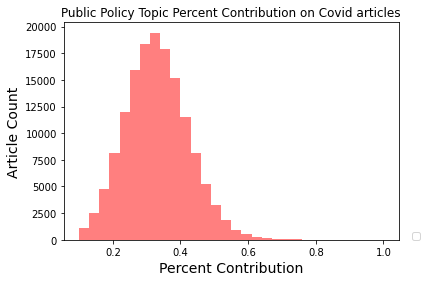

In [360]:
#histogram of public policy distrbution ranging from 10% to 100%
plt.hist(covid_vectors_df.public_policy,range=(0.1,1), bins = 30, alpha=0.5, color = 'red')
plt.xlabel("Percent Contribution", size = 14)
plt.ylabel("Article Count", size = 14)
plt.title('Public Policy Topic Percent Contribution on Covid articles')
plt.legend(loc=(1.04,0))

No handles with labels found to put in legend.


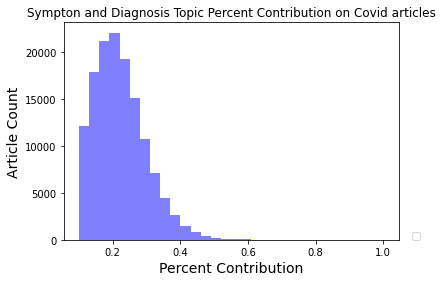

In [361]:
#histogram of symptom and diagnosis ranging from 10% to 100%
plt.hist(covid_vectors_df.symptoms_diagnosis, range=(0.1,1), bins = 30, alpha=0.5, color = 'blue')
plt.xlabel("Percent Contribution", size = 14)
plt.ylabel("Article Count", size = 14)
plt.title('Sympton and Diagnosis Topic Percent Contribution on Covid articles')
plt.legend(loc=(1.04,0))

No handles with labels found to put in legend.


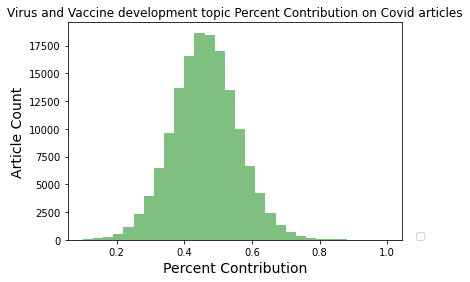

In [412]:
#histogram of virus and vaccine development ranging from 10% to 100%
plt.hist(covid_vectors_df.virus_vaccine,range=(0.1,1), bins = 30, alpha=0.5, color = 'green')
plt.xlabel("Percent Contribution", size = 14)
plt.ylabel("Article Count", size = 14)
plt.title('Virus and Vaccine development topic Percent Contribution on Covid articles')
plt.legend(loc=(1.04,0))

By looking at the topic distributions for the unseen covid data it is noticed that not many documents had a high topic percentage for any of the topics. This can be a sign that our topic model may be overfit or that the unseen covid papers discuss relatively different topics than the ones found. 

## (4) Insights and Guidance

People who are researching into COVID-19 (whether its scientists, doctors, nurses, healthcare professionals, industry or government) this model can be of use. Throughout this assignment i have explained in the designated sections the approach and what potential insights about COVID-10 could be achieved. 

To demonstrate the use of the insights that can be of use from this model i will be going through an example. 

Example: I am a researcher looking into the relationship between the development of viruses from the past to see if i can find any infromation or articles to potentially provide me with more insight into COVID-19. Many viruses have some sort of relationship to each other so to understand the relationship of the development of past viruses i can make insights about the new COVID-19 virus. 

In [363]:
#using dataframe that has the original abstract and dominant topics 
df_final.head()

,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,abstract,topic
0,1.0,0.9576,"respiratory, clinical, infections, influenza, sample, children, group, test, viruses, associate","[objective, retrospective_chart, review, describe, epidemiology, clinical, feature, culture, pro...",objective: this retrospective chart review describes the epidemiology and clinical features of 4...,Symptoms and diagnosis
1,2.0,0.6438,"viral, cells, viruses, protein, use, cell, sequence, host, human, show","[inflammatory, diseases, respiratory_tract, commonly, associate, elevate, production, nitric_oxi...",inflammatory diseases of the respiratory tract are commonly associated with elevated production ...,Virus and vaccine development
2,2.0,0.9028,"viral, cells, viruses, protein, use, cell, sequence, host, human, show","[surfactant, protein, participate, innate, response, inhale, microorganisms, organic, antigens, ...",surfactant protein-d (sp-d) participates in the innate response to inhaled microorganisms and or...,Virus and vaccine development
3,2.0,0.8650,"viral, cells, viruses, protein, use, cell, sequence, host, human, show","[endothelin, amino_acid, peptide, diverse, biological, activity, implicate, numerous, diseases, ...",endothelin-1 (et-1) is a 21 amino acid peptide with diverse biological activity that has been im...,Virus and vaccine development
4,2.0,0.8561,"viral, cells, viruses, protein, use, cell, sequence, host, human, show","[respiratory_syncytial, pneumonia, mice, viruses, family_paramyxoviridae, subfamily, pneumovirus...",respiratory syncytial virus (rsv) and pneumonia virus of mice (pvm) are viruses of the family pa...,Virus and vaccine development


In [407]:
#filtering the database for only Virus and Vaccine development topics 
virus_vaccine = df_final[df_final['topic'].str.contains('Virus and vaccine development')]

#finding the max percentage 
relevant_paper = virus_vaccine["Topic_Perc_Contrib"].max()
relevant_paper

0.9979000091552734

In [406]:
#filtering for relevant paper
relevant_paper = virus_vaccine.loc[virus_vaccine['Topic_Perc_Contrib'] > 0.9979]

#getting only the original abstract
abstract_searched = relevant_paper['abstract']

#displaying the whole abstract to read and get insight 
with pd.option_context('display.max_colwidth', None):
  display(abstract_searched)

141931    influenza viruses are enveloped, negative stranded, segmented rna viruses belonging to orthomyxoviridae family. each virion consists of three major subviral components, namely (i) a viral envelope decorated with three transmembrane proteins hemagglutinin (ha), neuraminidase (na) and m2, (ii) an intermediate layer of matrix protein (m1), and (iii) an innermost helical viral ribonucleocapsid [vrnp] core formed by nucleoprotein (np) and negative strand viral rna (vrna). since complete virus particles are not found inside the cell, the processes of assembly, morphogenesis, budding and release of progeny virus particles at the plasma membrane of the infected cells are critically important for the production of infectious virions and pathogenesis of influenza viruses as well. morphogenesis and budding require that all virus components must be brought to the budding site which is the apical plasma membrane in polarized epithelial cells whether in vitro cultured cells or in vivo infe

#### Article that provides insight

"influenza viruses are enveloped, negative stranded, segmented rna viruses belonging to orthomyxoviridae family. each virion consists of three major subviral components, namely (i) a viral envelope decorated with three transmembrane proteins hemagglutinin (ha), neuraminidase (na) and m2, (ii) an intermediate layer of matrix protein (m1), and (iii) an innermost helical viral ribonucleocapsid [vrnp] core formed by nucleoprotein (np) and negative strand viral rna (vrna). since complete virus particles are not found inside the cell, the processes of assembly, morphogenesis, budding and release of progeny virus particles at the plasma membrane of the infected cells are critically important for the production of infectious virions and pathogenesis of influenza viruses as well. morphogenesis and budding require that all virus components must be brought to the budding site which is the apical plasma membrane in polarized epithelial cells whether in vitro cultured cells or in vivo infected animals. ha and na forming the outer spikes on the viral envelope possess apical sorting signals and use exocytic pathways and lipid rafts for cell surface transport and apical sorting. np also has apical determinant(s) and is probably transported to the apical budding site similarly via lipid rafts and/or through cortical actin microfilaments. m1 binds the np and the exposed rnas of vrnps, as well as to the cytoplasmic tails (ct) and transmembrane (tm) domains of ha, na and m2, and is likely brought to the budding site on the piggy-back of vrnp and transmembrane proteins. budding processes involve bud initiation, bud growth and bud release. presence of lipid rafts and assembly of viral components at the budding site can cause asymmetry of lipid bilayers and outward membrane bending leading to bud initiation and bud growth. bud release requires fusion of the apposing viral and cellular membranes and scission of the virus buds from the infected cellular membrane. the processes involved in bud initiation, bud growth and bud scission/release require involvement both viral and host components and can affect bud closing and virus release in both positive and negative ways. among the viral components, m1, m2 and na play important roles in bud release and m1, m2 and na mutations all affect the morphology of buds and released viruses. disassembly of host cortical actin microfilaments at the pinching-off site appears to facilitate bud fission and release. bud scission is energy dependent and only a small fraction of virus buds present on the cell surface is released. discontinuity of m1 layer underneath the lipid bilayer, absence of outer membrane spikes, absence of lipid rafts in the lipid bilayer, as well as possible presence of m2 and disassembly of cortical actin microfilaments at the pinching off site appear to facilitate bud fission and bud release. we provide our current understanding of these important processes leading to the production of infectious influenza virus particles."

### Potential Insights and Guidance
This article is clearly discussing about the make up of influenza viruses. It explains how they are developed and virus components. Someone researching into COVID-19 could read this and the insight of influenza viruses. It specifically states "the processes involved in bud initiation, bud growth and bud scission/release require involvement both viral and host components and can affect bud closing and virus release in both positive and negative ways. among the viral components, m1, m2 and na play important roles in bud release and m1, m2 and na mutations all affect the morphology of buds and released viruses." 

This provides insight into bud initiation, bud growth and bud scission/release and its affects which is related to released viruses. Information like this can lead researchers to investigate bud initiation, growth and release to determine the development of the COVID-19 virus which is important because once there is an understanding of how the virus is developed then the path to find a treatment is smoother.
Since this is only the abstract, not all the information can be pulled from here but if a researcher reads something that they are interested in learning more about they can easily access the whole article.
